In Exercise 3, we will build a model for multiple object detection with a simple version of YOLO

# Import libs

In [12]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import tqdm.notebook as tqdm

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

# Data

## Download

In [13]:
import kagglehub

current_dir = os.getcwd()
os.environ['KAGGLEHUB_CACHE'] = current_dir
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print(f"Data directory: {data_dir}")

Data directory: c:\Learning\AIO\AIO24\Module7\ObjectDetection_Part1\datasets\andrewmvd\dog-and-cat-detection\versions\1


In [38]:
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform = None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform

        # Get all XML files in the annotations directory
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_images_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                file_name = f
                annotation_name = os.path.splitext(file_name)[0] + '.xml'
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                # Only keep images with single object
                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_images_files.append(file_name)
                else:
                    print(f"Skipping {file_name} due to multiple objects in annotation.")
        return valid_images_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            return len(root.findall('object'))
        except FileNotFoundError:
            return 0
        
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if (label is None):
                label = name
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)

                bbox = [
                    xmin/image_width,
                    ymin/image_height,
                    xmax/image_width,
                    ymax/image_height
                ]
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        if label_num == -1:
            raise ValueError(f"Unknown label {label} in annotation {annotation_path}.")
        return label_num, torch.tensor(bbox, dtype=torch.float32)
        
    def __len__(self): 
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # Adjust bbox coordinates for objects from img1 AND normalize
        new_bbox1 = [
            img1_annotations[1][0] * img1.width / merged_w,  # Normalize xmin
            img1_annotations[1][1] * img1.height / merged_h,  # Normalize ymin
            img1_annotations[1][2] * img1.width / merged_w,  # Normalize xmax
            img1_annotations[1][3] * img1.height / merged_h,  # Normalize ymax
        ]
        merged_annotations.append({"bbox": new_bbox1, "label": img1_annotations[0]})

        # Adjust bbox coordinates for objects from img2 AND normalize
        new_bbox2 = [
            (img2_annotations[1][0] * img2.width + img1.width)
            / merged_w,  # Normalize xmin
            img2_annotations[1][1] * img2.height / merged_h,  # Normalize ymin
            (img2_annotations[1][2] * img2.width + img1.width)
            / merged_w,  # Normalize xmax
            img2_annotations[1][3] * img2.height / merged_h,  # Normalize ymax
        ]

        merged_annotations.append({"bbox": new_bbox2, "label": img2_annotations[0]})

        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        # Convert annotations to 1D tensors, with shape (4,) for bbox and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat(
                (torch.tensor(ann["bbox"]), torch.tensor([ann["label"]]))
            )

        return merged_image, annotations


In [39]:
annotation_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(annotations_dir=annotation_dir, image_dir=image_dir, transform=data_transforms)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Skipping Cats_Test736.png due to multiple objects in annotation.


In [40]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modeling

## Main model

In [17]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classses =  num_classes

        # Remove the last fully connected layer and the average pooling layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fc = nn.Linear(
            2048, 2 * 2 * (4 + self.num_classses) # 2x2 grid, 4 bbox coords + num_classes
        )

    def forward(self, x):
        # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        # x shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)
        # x shape: (batch_size, 2048)
        x = self.fc(features)
        return x

## Calculating loss

In [18]:
def calculate_loss(output, target, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()
    
    batch_size = output.size(0)
    total_loss = 0
    output = output.view(batch_size, 2, 2, 4 + num_classes) # Reshape to (batch_size, 2, 2, 4 + num_classes)

    for i in range(batch_size):
        for j in range(len(target[i])): # Iterrate over each object in the batch
            # Determine the grid cell that the object belongs to
            # Assume that the image is normalized to [0, 1]
            center_x = (target[i][j][0] + target[i][j][2]) / 2
            center_y = (target[i][j][1] + target[i][j][3]) / 2

            grid_x = int(center_x * 2) # 2x2 grid
            grid_y = int(center_y * 2)

            # 1. Classification loss
            # Use one-hot encoding for the class label
            class_label_one_hot = torch.zeros(num_classes, device = device)
            class_label_one_hot[int(target[i][j][4])] = 1

            classification_loss = ce_loss(
                output[i][grid_y][grid_x][4:],
                class_label_one_hot
            )

            # 2. Regression Loss
            bbox_target = target[i][j][:4]
            regression_loss = mse_loss(
                output[i][grid_y][grid_x][:4],
                bbox_target
            )

            # 3. No object loss
            no_obj_loss = 0.0

            for k in range(2):
                for l in range(2):
                    if k != grid_x or l != grid_y:
                        no_obj_loss += mse_loss(
                            output[i][l][k][:4],
                            torch.zeros(4, device = device)
                        )

            # Combine the loss
            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size

## Training and evaluating functions

In [19]:
def evaluate_model(model, data_loader, device, num_classes ):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = calculate_loss(outputs, targets, device, num_classes)

            running_loss += loss.item()
            
            outputs = outputs.view(outputs.size(0), 2, 2, 4 + num_classes)

            for i in range(images.size(0)):
                for j in range(len(targets[i])):
                    center_x = (targets[i][j][0] + targets[i][j][2]) / 2
                    center_y = (targets[i][j][1] + targets[i][j][3]) / 2

                    grid_x = int(center_x * 2)
                    grid_y = int(center_y * 2)

                    prediction = outputs[i, grid_y, grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)
                    all_targets.append(targets[i][j][4].item())

    avg_loss = running_loss / len(data_loader)

    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)
    accuracy = (all_predictions == all_targets).float().mean()

    return avg_loss, accuracy.item()

In [20]:
def train(model, train_loader, val_loader, optimizer, device, num_epochs, num_classes, model_path):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        

        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = calculate_loss(outputs, targets, device, num_classes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_path, 'best_model.pth'))

        print(f"Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

## Train the model

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleYOLO(num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
model_path = os.path.join(current_dir, 'model')
os.makedirs(model_path, exist_ok=True)

device

device(type='cuda')

In [43]:
train_losses, val_losses, val_accuracies = train(
    model, train_loader, val_loader, optimizer, device, num_epochs, 2, model_path
)

Train Loss: 0.8930, Validation Loss: 1.6596, Validation Accuracy: 0.7212
Train Loss: 0.5576, Validation Loss: 0.5356, Validation Accuracy: 0.9654
Train Loss: 0.5154, Validation Loss: 0.6408, Validation Accuracy: 0.9450
Train Loss: 0.4497, Validation Loss: 0.3858, Validation Accuracy: 0.9844
Train Loss: 0.4126, Validation Loss: 0.6883, Validation Accuracy: 0.9254
Train Loss: 0.3917, Validation Loss: 0.4361, Validation Accuracy: 0.9742
Train Loss: 0.3812, Validation Loss: 1.1087, Validation Accuracy: 0.9023
Train Loss: 0.5704, Validation Loss: 0.6089, Validation Accuracy: 0.9457
Train Loss: 0.4295, Validation Loss: 0.3808, Validation Accuracy: 0.9830
Train Loss: 0.3476, Validation Loss: 0.3965, Validation Accuracy: 0.9837
Train Loss: 0.3508, Validation Loss: 0.4188, Validation Accuracy: 0.9722
Train Loss: 0.3725, Validation Loss: 0.4912, Validation Accuracy: 0.9668
Train Loss: 0.3759, Validation Loss: 0.3500, Validation Accuracy: 0.9891
Train Loss: 0.3376, Validation Loss: 0.4579, Valida

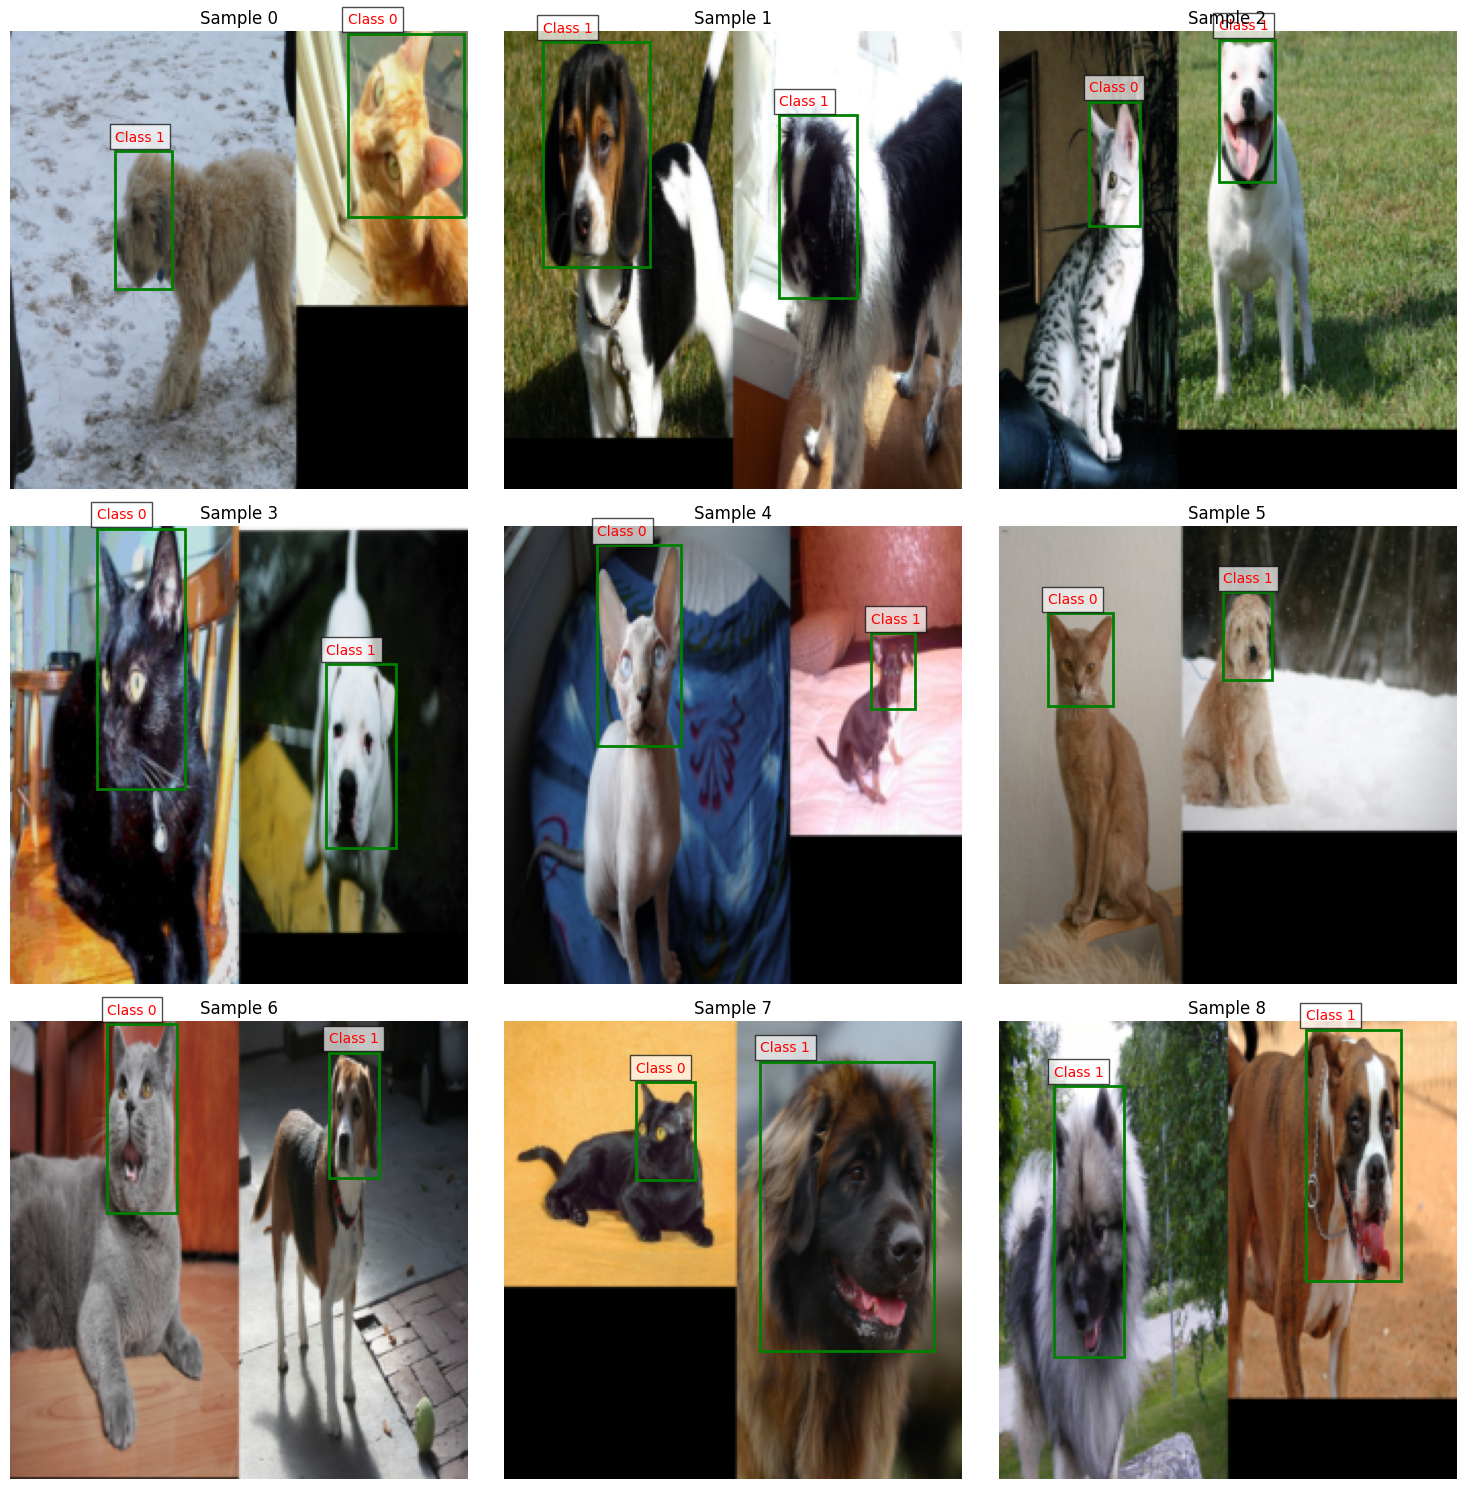

In [46]:
def visualize_data_samples(dataset, num_rows=3, num_cols=3, start_idx=0, class_to_idx=None):
    """
    Visualize samples from dataset with bounding boxes and labels
    
    Args:
        dataset: Dataset to visualize
        num_rows: Number of rows in grid
        num_cols: Number of columns in grid 
        start_idx: Starting index in dataset
        class_to_idx: Dictionary mapping class names to indices
    """
    # Add denormalization transform

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        merged_image, annotations = dataset[start_idx + idx]

        # Denormalize the image before converting to PIL
        if isinstance(merged_image, torch.Tensor):
            # Clamp values to [0,1] range
            merged_image = torch.clamp(merged_image, 0, 1)
            image = transforms.ToPILImage()(merged_image)
        else:
            image = merged_image

        ax.imshow(image)

        # Draw each bounding box on the image
        for ann in annotations:
            bbox = ann[:4]
            label = int(ann[4].item())

            # Scale bounding box coordinates to image size
            width, height = image.size
            x_min = bbox[0] * width
            y_min = bbox[1] * height
            x_max = bbox[2] * width
            y_max = bbox[3] * height

            # Create a rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label text if class_to_idx is provided
            if class_to_idx:
                label_name = class_to_idx.get(label, f"Class {label}")
                ax.text(
                    x_min,
                    y_min - 5,
                    label_name,
                    color="r",
                    fontsize=10,
                    bbox=dict(facecolor="white", alpha=0.7),
                )

        ax.set_title(f"Sample {start_idx + idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Plot first grid (images 0-8)
class_to_idx = {"dog": 0, "cat": 1}
visualize_data_samples(val_dataset, start_idx=0, class_to_idx=class_to_idx)
